## <font color='navy'> Examen 4. Laboratorio de Aprendizaje Estadístico.
    
### <font color='navy'> PCA, KMeans y Learners

Luis Fernando Márquez Bañuelos | 744489

In [1]:
import shap
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, LGBMRegressor, early_stopping, log_evaluation, plot_importance

pd.set_option('display.float_format', '{:,.4f}'.format)

## <font color='navy'> Importación de datos

In [2]:
data = pd.read_csv('hr_role.csv')
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_satisfied
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,80,0,8,0,1,6,4,0,5,True
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,80,1,10,3,3,10,7,1,7,False
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,80,0,7,3,3,0,0,0,0,False
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,80,0,8,3,3,8,7,3,0,False
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,80,1,6,3,3,2,2,2,2,False


## <font color='navy'> Funciones

In [3]:
def histograma(probabilidades: np.ndarray, y_test: str):
    juntar = pd.DataFrame({
    'real': y_test,
    'probabilidades': probabilidades
    })
    plt.figure(figsize=(10, 5))
    plt.hist(juntar[juntar.real == 1]['probabilidades'], density=True, alpha=0.5, label = '1', color= 'skyblue')
    plt.hist(juntar[juntar.real == 0]['probabilidades'], density=True, alpha=0.5, label = '0', color = 'indianred')
    plt.title(f'Histograma de probabilidades de')
    plt.xlabel('Probabilidad')
    plt.ylabel('Densidad')
    plt.legend()
    plt.show()

## <font color='navy'> Preparación de Datos

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  MaritalStatus           

Ninguna de las variables del dataset tiene datos nulos, por lo que no será necesario hacer limpieza de datos. Sin embargo se pueden poner multiples variables en un tipo más adecuado.

In [5]:
categorical_cols = [
    'BusinessTravel', 'Department', 'EducationField',
    'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime'
]

int8_cols = ['Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction',
             'JobInvolvement', 'JobLevel', 'RelationshipSatisfaction',
             'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance']

int32_cols = [
    'DailyRate', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate',
    'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating',
    'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole',
    'YearsSinceLastPromotion', 'YearsWithCurrManager'
]

data[int8_cols] = data[int8_cols].astype('int8')
data[int32_cols] = data[int32_cols].apply(pd.to_numeric, downcast='integer')
data[categorical_cols] = data[categorical_cols].astype('category')

In [6]:
data['Attrition'] = data['Attrition'].map({'Yes': True, 'No': False})
target = 'Attrition'
data = pd.get_dummies(data)

In [7]:
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

## <font color='navy'> 1- PCA

In [8]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])
pipeline.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

In [9]:
objeto_pca = pipeline.named_steps['pca']
X_pca = pipeline.transform(X)
X_componentes = pd.DataFrame(X_pca, columns=[f'PCA {i+1}' for i in range(X_pca.shape[1])])
X_componentes.head()

,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,PCA 8,PCA 9,PCA 10,...,PCA 44,PCA 45,PCA 46,PCA 47,PCA 48,PCA 49,PCA 50,PCA 51,PCA 52,PCA 53
0,-0.0303,-2.3304,-1.1614,-3.2175,-0.1139,0.2535,-1.0405,0.3092,-0.4480,2.1116,...,0.0149,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000
1,0.0497,1.5437,-0.2139,1.6625,0.7196,-2.2080,1.0955,-1.0808,2.4273,1.2482,...,-0.1029,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000
2,-2.9220,0.9963,-0.2068,-1.5847,-0.0958,0.0983,-2.7826,0.8389,0.4165,-0.6430,...,-0.0992,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000
3,-1.1874,1.0543,-0.6928,-2.3067,-0.2285,-2.3924,1.0586,-0.0715,-1.8439,1.8181,...,0.0460,-0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000
4,-2.1227,1.1964,0.5328,1.2881,-0.6940,1.6858,-0.5015,0.2727,-0.6313,-1.7150,...,0.1490,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000


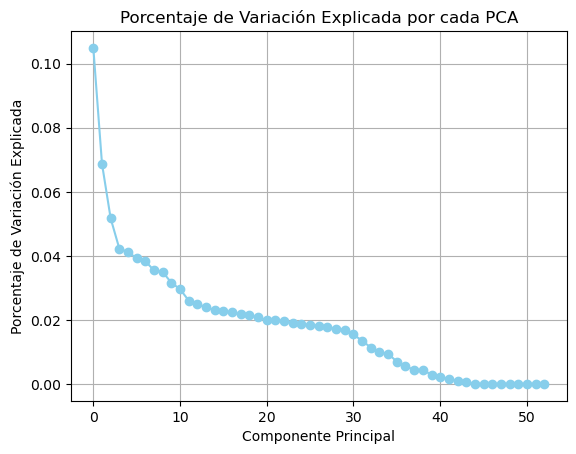

In [10]:
plt.plot(objeto_pca.explained_variance_ratio_, marker='o', color = 'skyblue')
plt.title('Porcentaje de Variación Explicada por cada PCA')
plt.xlabel('Componente Principal')
plt.ylabel('Porcentaje de Variación Explicada')
plt.grid()
plt.show()

In [11]:
variances = [objeto_pca.explained_variance_ratio_[i] for i in range(len(objeto_pca.explained_variance_ratio_))]

for i in range(10):
    print(f'La varianza explicada por el PCA {i+1} es {variances[i]:.4f}')

La varianza explicada por el PCA 1 es 0.1049
La varianza explicada por el PCA 2 es 0.0687
La varianza explicada por el PCA 3 es 0.0517
La varianza explicada por el PCA 4 es 0.0423
La varianza explicada por el PCA 5 es 0.0412
La varianza explicada por el PCA 6 es 0.0392
La varianza explicada por el PCA 7 es 0.0384
La varianza explicada por el PCA 8 es 0.0354
La varianza explicada por el PCA 9 es 0.0350
La varianza explicada por el PCA 10 es 0.0316


Para esta parte se obtuvieron las PCA de nuestros datos, esto es de utilidad ya que se tiene un dataset con más de 50 variables, por lo que poder reducir su dimensionalidad puede ayudar a entrenar más rapido el modelo y cargarlo con tanta información. La gráfica nos muestra como disminuye el porcentaje de varianza de los datos que explica cada una de las PCA donde despues de la PCA 30 la varianza que explican es muy baja. Viendo las primeras 10 componentes principales claramente son las que más varianza explican ya que con solo un 20% de las variables se puede explicar el 50% de la varianza en nuestrso datos, lo cual representa en una fuerte reducción de dimensionalidad.

## <font color='navy'> 2- KMeans

### <font color='cornflowerblue'> Gráfica del codo

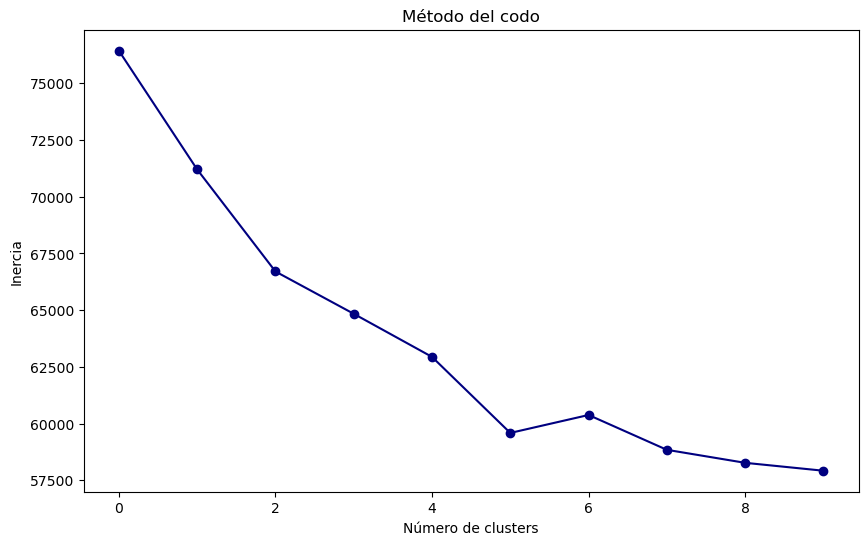

In [12]:
data.dropna(axis=0, inplace=True)

# Guarda la varianza del cluster o "inertia"
inertias = []

# ¿Cuantos clusters probar?
K_range = range(1, 11)
for i in K_range:
    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=i, random_state=42))
    ])
    pipeline.fit(data)
    inertias.append(pipeline.named_steps['kmeans'].inertia_)

plt.figure(figsize=(10, 6))
plt.plot(inertias, marker = 'o', c = 'navy')
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.show()

In [13]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=42))
])
pipeline.fit(data)

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

In [14]:
data['cluster'] = pipeline.predict(data)

### <font color='cornflowerblue'> Análisis de clusters

In [15]:
pct = data.groupby('cluster').mean()
pct

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
cluster,,,,,,,,,,,,,,,,,,,,,
0,34.9138,0.1663,801.5567,9.1650,2.8534,2.7500,66.1897,2.7451,1.4975,"4,144.3276",...,0.0000,0.3584,0.0000,0.0000,0.2278,0.4446,0.3276,1.0000,0.7266,0.2734
1,35.1504,0.2206,800.0526,9.3885,2.9123,2.6792,65.1930,2.6967,2.0351,"5,911.9699",...,0.0000,0.0000,0.7870,0.2080,0.1955,0.4536,0.3509,1.0000,0.7093,0.2907
2,45.9575,0.0541,809.1467,8.9768,3.1004,2.6988,66.0309,2.7336,3.8842,"14,807.8726",...,0.3089,0.0039,0.0463,0.0000,0.2471,0.5058,0.2471,1.0000,0.6988,0.3012


De acuerdo a la gráfica del codo, este se encuentra en tres clusters por lo que será el número utilizado para agrupar a las personas del dataset. Viendo los clusters nos puede permitir encontrar iinformación importante que contribuya al attrition, por ejemplo el cluster 2 es el que menos attrition tiene con solo un 5.41%, sin embargo, tiene el promedio de edad más alto que es 45 y el ingreso más alto siendo el triple que el de los otros dos clusters con un attrition bastante superior, por lo que el ingreso tiene un impacto en si el empleado se queda en la empresa lo cual es muy común en la realidad.

De manera general tanto el cluster 0 y 1 son muy similares ya que su edad promedio e ingreso promedio son casi iguales, y teniendo mucha más gente que ya se fue de la empresa dentro de estos clusters. Algo que es interesante es que al menos de acuerdo a la forma de segmentar, los tres grupos el porcentaje de personas que trabaja horas extra es similar, sin embargo, el grupo 2 teniendo un salario mucho más alto puede indicar que los grupos 0 y 1 no reciben buena remuneración por el tiempo extra lo cual puede oncrementar el attrition.

## <font color='navy'> 3- Hacer modelos

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### <font color='cornflowerblue'> LightGBM variables

In [17]:
model = LGBMClassifier(
    n_estimators=200,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1,
    random_state=42,
    early_stopping_rounds=20,
    eval_metric='auc',
    n_jobs=-1
)


model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='auc',
          callbacks=[early_stopping(20),
                     log_evaluation(100)])

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	training's auc: 0.991691	training's binary_logloss: 0.152619	valid_1's auc: 0.781197	valid_1's binary_logloss: 0.319638


LGBMClassifier(early_stopping_rounds=20, eval_metric='auc',
               feature_fraction=0.8, lambda_l2=0.1, max_depth=6,
               n_estimators=200, n_jobs=-1, num_leaves=10, random_state=42,
               subsample=0.8, verbosity=-1)

In [18]:
probabilidades = model.predict_proba(X_test)[:, 1]
lgbm_auc = roc_auc_score(y_test, probabilidades)
print(f'AUC: {lgbm_auc:.4f}')

AUC: 0.7812


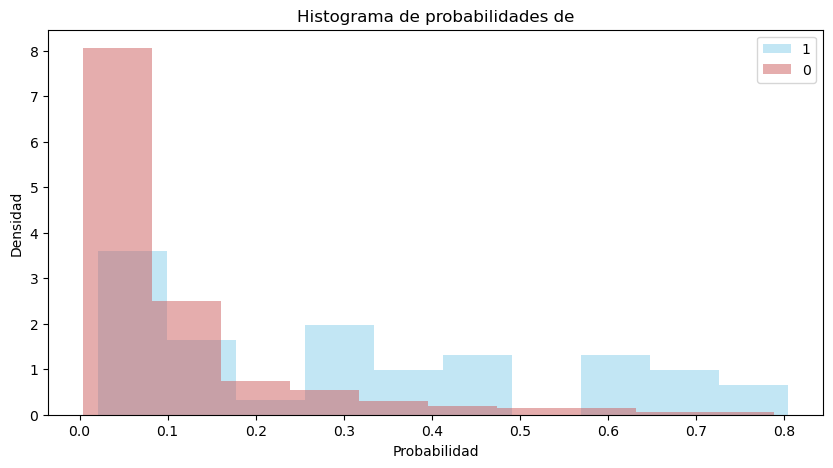

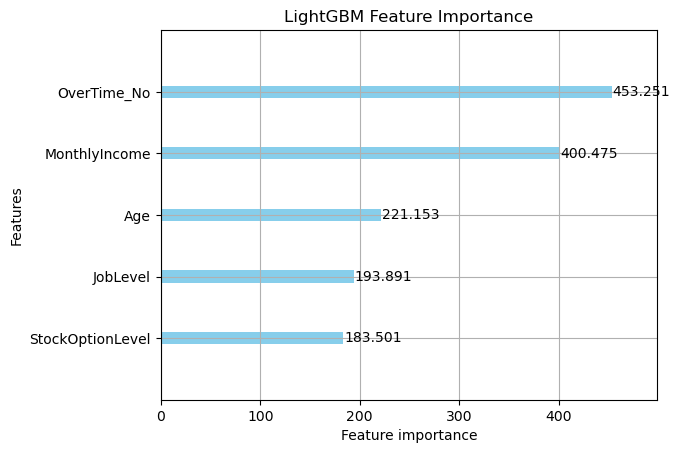

In [19]:
histograma(probabilidades, y_test)
plot_importance(model, max_num_features=5, importance_type='gain', title='LightGBM Feature Importance', color='skyblue')
plt.show()

El modelo realizado obtuvo un AUC de 0.78, lo cual implica una alta capacidad en la distinción de clases, por lo que se puede decir que el modelo es bueno para predecir de acuerdo a las características de las personas si está tiene una mayor probabilidad de irse de la empresa. Por lo general clasifica muy bien a quienes se quedan en la empresa con un poco más de problema para la clasificación de la clase 1, sin llegar a ser un mal modelo. 

Según el modelo las variables más importantes son saber siy no trabaja horas extra, su ingreso mensual y su edad. Esto ya se podía intuir en el análisis de los clusters y vemos que en el modelo realizado en efecto tienen un alto impacto. Las otras dos variables son el nivel de trabajo, donde si una persona tiene algún puesto muy alto influye en su perspectiva de la empresa, además de las opciones de acciones que tengan las cuales suelen representar mucho dinero. Con esto se puede decir que las variables que el modelo considera importante en la práctica son factores que las personas consideran al estar en un trabajo.

### <font color='cornflowerblue'> Shap values

In [20]:
# Sample
X_shap = X_test.sample(290, random_state=42)

# Inicializa los shaps explainer SHAP, shap.TreeExplainer
explainer = shap.TreeExplainer(model)

# explainer.shap_values
shap_values = explainer.shap_values(X_shap)

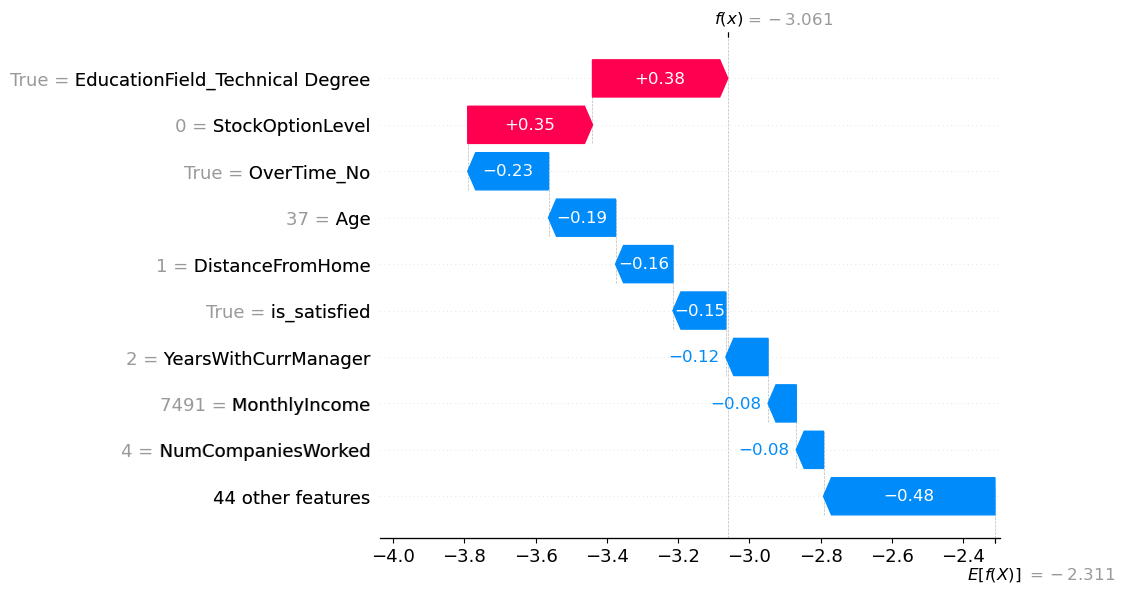

In [21]:
# Incicializa los shaps  initjs()
shap.initjs()

# Para visualizar shap individual con waterfall plot
n_dato = 0

# Visualiza el shap individual
shap.waterfall_plot(shap.Explanation(
        values=shap_values[n_dato],
        base_values=explainer.expected_value,
        data=X_shap.iloc[n_dato],
        feature_names=X_shap.columns
))

Los shap values de la gráfica son para una obervación en específico y nos describen a detalla como las variables impactan en la clasificación de esta persona. Por la predicción f(x) vemos que fue clasificado con un 0, es decir, que sigue en la empresa. Esto lo vemos por la amplia expiriencia que tiene pues ha trabajado en otros cuatro lugares, su edad de 3 años y su alto ingreso dentro de la empresa que de acuerdo al modelo estos fcatores tiene un impacto fuerte en clasificar a esta persona como 0.

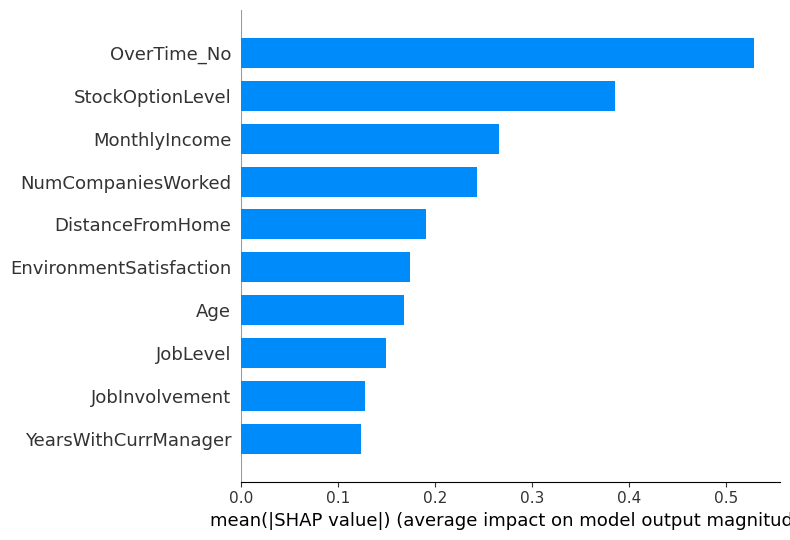

In [22]:
shap.summary_plot(shap_values, X_shap, plot_type="bar", max_display=10)

En esta gráfica se ve el impacto promedio de las variables al momento de clasificar, nos da una vista general de la importancia de las distintas características de las personas en general. Vemos que lo más importante es si trabaja tiempo extra, el nivel de opciones que tiene y su ingreso mensual. Dos de estas están relacionadas con dinero, lo cual es de esperar al hablar de un modelo que clasifica si alguien se queda o se va de un trabajo, ya que un factor muy importante es la cantidad de dinero que puedes ganar, por lo que a través de todas las personas el modelo le da un alto peso a lo relacionado con el dinero al momento de hacer sus predicciones.

Otros aspectos importantes fueron la edad y su satisfacción con el ambiente, lo cual hace sentido, ya que hay ciertas edades donde las personas buscan estabilidad por lo que cambiar de trabajo no siempre lo ven como una gran opción, más si están cómodos con el ambiente lo que el modelo considera muy importante. Además la distancia de tu casa al trabajo el modelo de da un alto impacto, lo cual se relaciona con el tiempo que puedes llegar a hacer al trabajo y para irte a tu casa, ya que no suele ser bien recibido que estos sean muy altos.

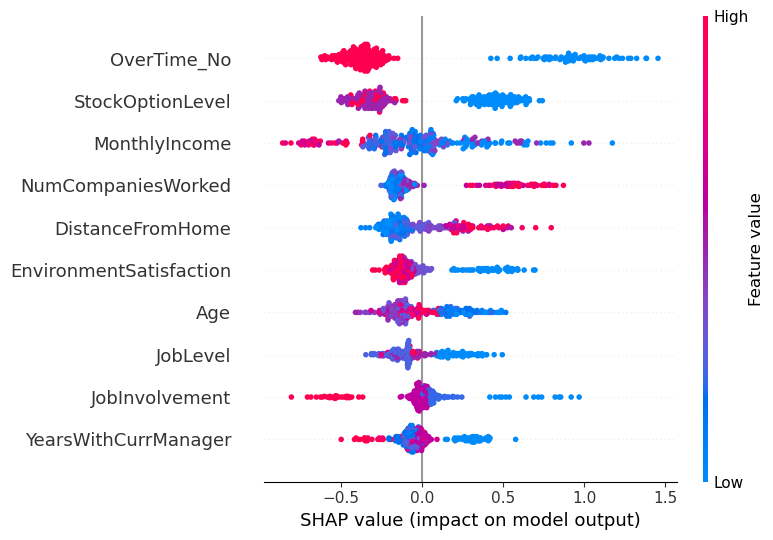

In [23]:
shap.summary_plot(shap_values, X_shap, plot_type="dot", max_display=10)

Con el dotplot de los shap values se pueden ver más detalles, por ejemplo altos niveles de opciones reducen la probabilidad de que la persona decida irse, así como una alta particpación en el trabajo ya que refleja compromiso con este. Por otro lado cosas como un bajo nivel de satisfacción con el ambiente laboral aumentan las probabilidades de que una persona decida irse ya no se siente cómodos. Algo interesante es que personas que hacen tiempo extra tienen una mayor probabilidad de dejar su empleo, esto puede ser por un alto desgaste que no se vea bien reflejado en su sueldo.

Otro aspecto interesante es que si se ha trabajado un alto número de empresas aumenta la probabilidad de dejar el empleo, lo cual tiene sentido ya que muestra el comportamiento general de estas personas que decidan cambiar frecuentemente de trabajo. Además que una alta distancia de casa al trabajo aumenta la probabilidad de dejar tu trabajo esto probablemnete por la inconveniencia de los traslados. Por último si bien no tiene un impacto tan importante, tener una mayor edad es un indicador de una mayor probabilidad de mantenerte en tu trabajo.

### <font color='cornflowerblue'> LightGBM PCA

In [24]:
XC_train = X_componentes.loc[X_train.index]
XC_test = X_componentes.loc[X_test.index]

In [25]:
model = LGBMClassifier(
    n_estimators=200,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1,
    random_state=42,
    early_stopping_rounds=20,
    eval_metric='auc',
    n_jobs=-1
)


model.fit(XC_train, y_train, eval_set=[(XC_train, y_train), (XC_test, y_test)],
          eval_metric='auc',
          callbacks=[early_stopping(20),
                     log_evaluation(100)])

Training until validation scores don't improve for 20 rounds


LGBMClassifier(early_stopping_rounds=20, eval_metric='auc',
               feature_fraction=0.8, lambda_l2=0.1, max_depth=6,
               n_estimators=200, n_jobs=-1, num_leaves=10, random_state=42,
               subsample=0.8, verbosity=-1)

In [26]:
probabilidades = model.predict_proba(XC_test)[:, 1]
lgbm_auc = roc_auc_score(y_test, probabilidades)
print(f'AUC: {lgbm_auc:.4f}')

AUC: 0.7624


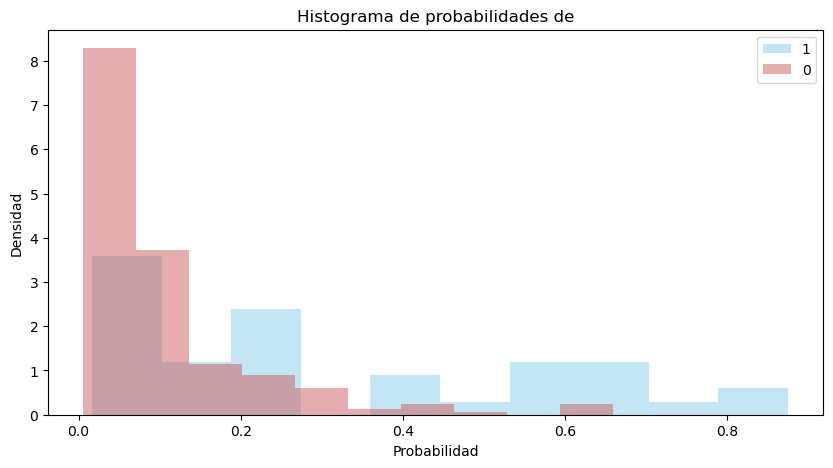

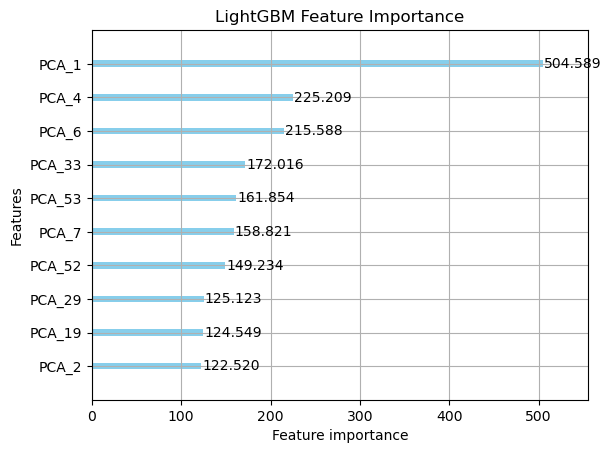

In [27]:
histograma(probabilidades, y_test)
plot_importance(model, max_num_features=10, importance_type='gain', title='LightGBM Feature Importance', color='skyblue')
plt.show()

El AUC obtenido de este modelo usando todas las PCA es ligeramete menor al del modelo original con las variables, sin embargo, lo importante del modelo es identificar variables importantes para hacer un modelo a través de estas reduciendo la dimensionalidad, ya que 50 variables osn bastantes.

Con la gráfica de plot importance se puede ver que las componentes más immportantes son la 1, 4, 6 y 33. A partir de estas la importancia disminuye considerablemente, además hace sentido que hayan sido importantes para el modelo puesto que están entre las primeras seis PCA que más reducen la varianza. Como punto interesante es que la PCA 33 haya sido de alta importancia considerando que su reducción de varianza es muy baja.

### <font color='cornflowerblue'> LightGBM PCA importantes

In [28]:
x_pca_train = XC_train[['PCA 1', 'PCA 4', 'PCA 6', 'PCA 33']]
x_pca_test = XC_test[['PCA 1', 'PCA 4', 'PCA 6', 'PCA 33']]

In [29]:
model = LGBMClassifier(
    n_estimators=200,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1,
    random_state=42,
    early_stopping_rounds=20,
    eval_metric='auc',
    n_jobs=-1
)


model.fit(x_pca_train, y_train, eval_set=[(x_pca_train, y_train), (x_pca_test, y_test)],
          eval_metric='auc',
          callbacks=[early_stopping(20),
                     log_evaluation(100)])

Training until validation scores don't improve for 20 rounds


LGBMClassifier(early_stopping_rounds=20, eval_metric='auc',
               feature_fraction=0.8, lambda_l2=0.1, max_depth=6,
               n_estimators=200, n_jobs=-1, num_leaves=10, random_state=42,
               subsample=0.8, verbosity=-1)

In [30]:
probabilidades = model.predict_proba(x_pca_test)[:, 1]
lgbm_auc = roc_auc_score(y_test, probabilidades)
print(f'AUC: {lgbm_auc:.4f}')

AUC: 0.6676


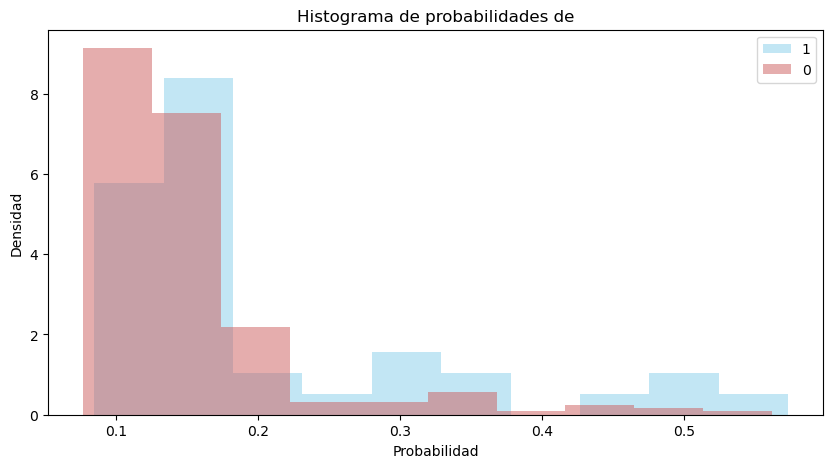

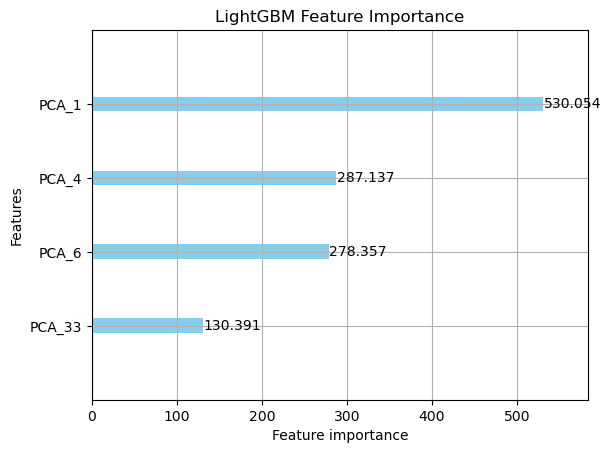

In [31]:
histograma(probabilidades, y_test)
plot_importance(model, max_num_features=10, importance_type='gain', title='LightGBM Feature Importance', color='skyblue')
plt.show()

Usando las cuatro PCA más importantes dle modelo anterior se obtuvo un AUC de 0.66 el cual es 12% más bajo que el modelo con las variables originales. A pesar de esto, el modelo aun tiene cierta capacidad de clasificación usando tan solo cuatro variables en comparación de 50, por lo que se lográ reducir la dimensionalidad significativamente y aún tener un modelo con cierto poder predictivo.

## <font color='navy'> 4- Dataset Diabetes

## <font color='navy'> Importación de datos

In [32]:
data = pd.read_csv('diabetes.csv')
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,diabetes
0,Female,80.0000,0,1,never,25.1900,0
1,Female,54.0000,0,0,No Info,27.3200,0
2,Male,28.0000,0,0,never,27.3200,0
3,Female,36.0000,0,0,current,23.4500,0
4,Male,76.0000,1,1,current,20.1400,0


## <font color='navy'> Preparación de datos

In [33]:
data['smoking_history'] = data['smoking_history'].map({'No Info': 0, 'never': 0, 'former': 1, 
                                                       'current': 1, 'not current': 1, 'ever':1})
data = pd.get_dummies(data, columns=['gender'])
target = 'diabetes'
data.head()

,age,hypertension,heart_disease,smoking_history,bmi,diabetes,gender_Female,gender_Male,gender_Other
0,80.0000,0,1,0,25.1900,0,True,False,False
1,54.0000,0,0,0,27.3200,0,True,False,False
2,28.0000,0,0,0,27.3200,0,False,True,False
3,36.0000,0,0,1,23.4500,0,True,False,False
4,76.0000,1,1,1,20.1400,0,False,True,False


In [34]:
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

### <font color='cornflowerblue'> S learner

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
model = LGBMClassifier(
    n_estimators=200,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1,
    random_state=42,
    early_stopping_rounds=20,
    eval_metric='auc',
    n_jobs=-1
)


model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='auc',
          callbacks=[early_stopping(50),
                     log_evaluation(100)])

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.839711	training's binary_logloss: 0.225697	valid_1's auc: 0.835882	valid_1's binary_logloss: 0.228713


LGBMClassifier(early_stopping_rounds=20, eval_metric='auc',
               feature_fraction=0.8, lambda_l2=0.1, max_depth=6,
               n_estimators=200, n_jobs=-1, num_leaves=10, random_state=42,
               subsample=0.8, verbosity=-1)

In [37]:
probabilidades = model.predict_proba(X_test)[:, 1]
lgbm_auc = roc_auc_score(y_test, probabilidades)
print(f'AUC: {lgbm_auc:.4f}')

AUC: 0.8359


In [38]:
# Pon 0 a todas las promos
X_test_counter_0 = X_test.copy()
X_test_counter_0['smoking_history'] = 0
# Pon 1 toda las promos
X_test_counter_1 = X_test.copy()
X_test_counter_1['smoking_history'] = 1

In [39]:
df_cate = pd.DataFrame({
    'treatment0' : model.predict_proba(X_test_counter_0)[:,1],
    'treatment1' : model.predict_proba(X_test_counter_1)[:,1]
})

df_cate['cate'] = df_cate['treatment1'] - df_cate['treatment0']
df_cate['bin_cate'] = pd.qcut(df_cate['cate'], q=5, labels=False) + 1
df_cate['diabetes_%'] = y_test
df_cate.groupby('bin_cate').mean()

,treatment0,treatment1,cate,diabetes_%
bin_cate,,,,
1,0.0102,0.0111,0.0009,0.0745
2,0.0156,0.0216,0.0059,0.0835
3,0.0421,0.0542,0.0121,0.0805
4,0.1116,0.1337,0.0220,0.1179
5,0.2049,0.2474,0.0424,0.0871


In [40]:
df_cate['cate'].describe()

count   20,000.0000
mean         0.0166
std          0.0160
min         -0.0582
25%          0.0045
50%          0.0120
75%          0.0248
max          0.1889
Name: cate, dtype: float64

De acuerdo al S learner realizado vemos que fumar si tiene ligero impacto en aumentar las probabilidades de tener diabetes ya que en promedio es 1.66%, si bien es muy bajo a final de cuentas muestra que existe un impacto entre fumar y tener diabetes, en casos extremos aumentando las probabilidades hasta en un 18%. En los bins creados vemos que en general en cada uno de los bins la proporción de perosnas con diabetes es similar entre sí, a pesar de que el impacto por fumar cada vez es mayor, esto esta en línea con que en promedio solo aumenta poco más del 1% la probabilidad de tener diabetes en caso de fumar, pero en ciertos segmentos puede aumentar las probabilidades en un 4.24%

### <font color='cornflowerblue'> T learner

In [41]:
# Train: Smoke = 1
X_train_smoke1 = X_train[X_train['smoking_history'] == 1]
y_train_smoke1 = y_train.loc[X_train_smoke1.index]

# Train: Smoke = 0
X_train_smoke0 = X_train[X_train['smoking_history'] == 0]
y_train_smoke0 = y_train.loc[X_train_smoke0.index]

# Test: Smoke = 1
X_test_smoke1 = X_test[X_test['smoking_history'] == 1]
y_test_smoke1 = y_test.loc[X_test_smoke1.index]

# Test: Smoke = 0
X_test_smoke0 = X_test[X_test['smoking_history'] == 0]
y_test_smoke0 = y_test.loc[X_test_smoke0.index]

y_train_smoke = X_train['smoking_history'].reset_index(drop=True)
y_test_smoke = X_test['smoking_history'].reset_index(drop=True)

In [42]:
model_t0 = LGBMClassifier(
    n_estimators=200,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1,
    random_state=42,
    early_stopping_rounds=20,
    eval_metric='auc',
    n_jobs=-1
)


model_t0.fit(X_train_smoke0, y_train_smoke0, eval_set=[(X_train_smoke0, y_train_smoke0), (X_test_smoke0, y_test_smoke0)],
          eval_metric='auc',
          callbacks=[early_stopping(20),
                     log_evaluation(100)])

Training until validation scores don't improve for 20 rounds


LGBMClassifier(early_stopping_rounds=20, eval_metric='auc',
               feature_fraction=0.8, lambda_l2=0.1, max_depth=6,
               n_estimators=200, n_jobs=-1, num_leaves=10, random_state=42,
               subsample=0.8, verbosity=-1)

In [43]:
model_t1 = LGBMClassifier(
    n_estimators=200,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1,
    random_state=42,
    early_stopping_rounds=20,
    eval_metric='auc',
    n_jobs=-1
)


model_t1.fit(X_train_smoke1, y_train_smoke1, eval_set=[(X_train_smoke1, y_train_smoke1), (X_test_smoke1, y_test_smoke1)],
          eval_metric='auc',
          callbacks=[early_stopping(20),
                     log_evaluation(100)])

Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.806482	training's binary_logloss: 0.309736	valid_1's auc: 0.793618	valid_1's binary_logloss: 0.312303
Early stopping, best iteration is:
[106]	training's auc: 0.80722	training's binary_logloss: 0.309285	valid_1's auc: 0.793827	valid_1's binary_logloss: 0.312178


LGBMClassifier(early_stopping_rounds=20, eval_metric='auc',
               feature_fraction=0.8, lambda_l2=0.1, max_depth=6,
               n_estimators=200, n_jobs=-1, num_leaves=10, random_state=42,
               subsample=0.8, verbosity=-1)

In [44]:
todos = X_test.copy()
todos = todos[X_train_smoke0.keys()]

df_cate = pd.DataFrame({
    'treatment0' : model_t0.predict_proba(todos)[:,1],
    'treatment1' : model_t1.predict_proba(todos)[:,1]
})
df_cate['cate'] = df_cate['treatment1'] - df_cate['treatment0']
df_cate.head()

,treatment0,treatment1,cate
0,0.0100,0.0044,-0.0056
1,0.0023,0.0044,0.0021
2,0.1065,0.1258,0.0193
3,0.0019,0.0082,0.0063
4,0.0794,0.0786,-0.0008


In [45]:
df_cate['bin_cate'] = pd.qcut(df_cate['cate'], q=5, labels=False) + 1
df_cate['diabetes_%'] = y_test
df_cate.groupby('bin_cate').mean()

,treatment0,treatment1,cate,diabetes_%
bin_cate,,,,
1,0.0650,0.0570,-0.0079,0.0793
2,0.0252,0.0289,0.0037,0.0745
3,0.0371,0.0473,0.0102,0.1011
4,0.0784,0.1001,0.0217,0.0971
5,0.1744,0.2399,0.0655,0.0923


In [46]:
df_cate['cate'].describe()

count   20,000.0000
mean         0.0186
std          0.0306
min         -0.2627
25%          0.0022
50%          0.0100
75%          0.0252
max          0.2790
Name: cate, dtype: float64

Para el caso del T learner se tiene resultados similares donde en promedio fumar aumenta las probabilidades de tener diabetes un 1.86%, donde incluso en bins bajos tiene un impacto negativo, pero esto se puede deber a un overfitting en los modelos o bien ser un impacto real. Además los segmentos 3, 4 y 5 tiene un 10% de personas con diabetes a pesar de ir incrmentando su cate d 1.02% hasta 6.55%. Aquí vemos que el T learner en el bin más alto considera un mayor aumento en la probabilidad de tener diabetes en caso de fumar, mientras que en los demás segmentos el cate es muy similar.

Esto continua una tendencia de que el impacto en la probabilidad de teenr diabetes a causa de fumar es relativamente bajo.

### <font color='cornflowerblue'> X learner

Recuperamos el T learner previamente calculado.

In [47]:
D0 = y_train_smoke1 - model_t0.predict_proba(X_train_smoke1)[:,1]
D1 = model_t1.predict_proba(X_train_smoke0)[:,1] - y_train_smoke0

In [48]:
mD0 = LGBMRegressor(
    n_estimators=10000,
    num_leaves=10,
    max_depth=5,
    learning_rate=0.1,
    colsample_bytree=0.8, 
    subsample=0.8,              
    metric='rmse',
    verbosity=-1  
)
mD0.fit(X_train_smoke1, D0)

mD1 = LGBMRegressor(
    n_estimators=10000,
    num_leaves=10,
    max_depth=5,
    learning_rate=0.1,
    colsample_bytree=0.8, 
    subsample=0.8,              
    metric='rmse',
    verbosity=-1
)
mD1.fit(X_train_smoke0, D1)

LGBMRegressor(colsample_bytree=0.8, max_depth=5, metric='rmse',
              n_estimators=10000, num_leaves=10, subsample=0.8, verbosity=-1)

In [49]:
X_train_ps = X_train.drop('smoking_history', axis=1)
X_test_ps = X_test.drop('smoking_history', axis=1)

propensity_model = LGBMClassifier(
    n_estimators=200,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1,
    random_state=42,
    early_stopping_rounds=20,
    eval_metric='auc',
    n_jobs=-1
)

propensity_model.fit(X_train_ps, y_train_smoke, eval_set=[(X_train_ps, y_train_smoke), (X_test_ps, y_test_smoke)],
                     eval_metric='auc',
                     callbacks=[early_stopping(20),
                                log_evaluation(100)])

Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.691938	training's binary_logloss: 0.543075	valid_1's auc: 0.689992	valid_1's binary_logloss: 0.543379
Early stopping, best iteration is:
[99]	training's auc: 0.691925	training's binary_logloss: 0.543084	valid_1's auc: 0.69001	valid_1's binary_logloss: 0.543361


LGBMClassifier(early_stopping_rounds=20, eval_metric='auc',
               feature_fraction=0.8, lambda_l2=0.1, max_depth=6,
               n_estimators=200, n_jobs=-1, num_leaves=10, random_state=42,
               subsample=0.8, verbosity=-1)

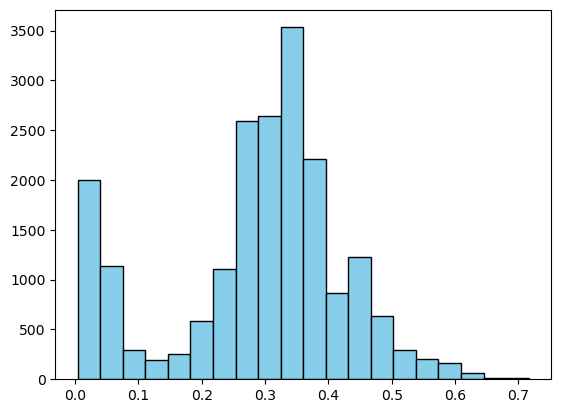

In [50]:
propensity_score = propensity_model.predict_proba(X_test_ps)[:, 1]
plt.hist(propensity_score, bins=20, color = 'skyblue', edgecolor = 'black');

In [51]:
predict_d1 = mD1.predict(X_test)
predict_d0 = mD0.predict(X_test)

In [52]:
cate = propensity_score * predict_d1 + (1 - propensity_score) * predict_d0
df_cate = pd.DataFrame({
    'cate': cate,
})
df_cate.head()

,cate
0,-0.0317
1,0.0008
2,0.0321
3,0.0259
4,-0.0240


In [53]:
df_cate['bin_cate'] = pd.qcut(df_cate['cate'], q=5, labels=False) + 1
df_cate['diabetes_%'] = y_test
df_cate.groupby('bin_cate').mean()

,cate,diabetes_%
bin_cate,,
1,-0.0664,0.0932
2,-0.0090,0.0826
3,0.0058,0.0955
4,0.0308,0.0873
5,0.1312,0.0849


In [54]:
df_cate['cate'].describe()

count   20,000.0000
mean         0.0184
std          0.0810
min         -0.7684
25%         -0.0128
50%          0.0051
75%          0.0387
max          0.8949
Name: cate, dtype: float64

Con el X learner realizado que es el método más complejo para encontrar la causalidad entre variables y la salida de respuesta vemos que mantiene resultados muy similares al otros dos learners. El cate promedio es de 1.84%, la distribución de personas con diabetes es relativamente igual a pesar de tener cates para los bins 4 y 5 de 3.08% y 13.12%, por lo que en general no es un impacto muy alto.

Sin embargo, el cate estimado en los últimos bins es mayor que en los otros dos modelos, por lo que en la parte alta de los valores del cate, el X learner estima un mayor efecto causal entre fumar y la probabilidad de tener diabetes.